### In this file, I am going to implement the multivariate predcition for the second series of dataset 


#### Preprocessing the data, and defining the necessary functions

In [8]:
### Import libraries
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint # to save the model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_squared_error as mse


In [9]:
data_path='./time-series-11-1_txt-file'

# iterate throguh txt files to make a dataframe of the data

os.chdir(data_path) # change the directory

df_as_np=np.zeros((900,2000)) # create a numpy array with 900 series of time and 2000 of wavelnegth (i below is equal to 900)

i=-1
for file in os.listdir():
    # Check whether file is in text format or not
    if (file.endswith(".txt")) and (i<899): # added the second condition to pick the data only up to time 1200 
        file_path = f"{data_path}\{file}"
        columns=[]
        data=[]
        i=i+1
        with open(file_path) as f:
            lines = f.readlines()
            for line in lines:
                column=line.split(' ')[0] # get the columns
                column=column.translate(str.maketrans('','','+')) # removing the + character, so we can convert the string to float
                columns.append(float(column))

                phot=line.split(' ')[1] # get the intensity value
                phot=phot.replace('\n','') # remove the character \n at the end of the values
                phot=phot.translate(str.maketrans('','','+')) # removing the + character, so we can convert the string to float
                data.append(float(phot))
         
        df_as_np[i,:]=np.array(data)



In [10]:
df_as_np[df_as_np < 0]=0 # delete the negative values 
df=pd.DataFrame(df_as_np, columns=columns) # add columns to the dataFrame
df

1.838336  1.838139  1.837942  1.837745  1.837548  1.837351  1.837154  \
0         9.0       1.0       0.0       0.0       3.0       3.0       0.0   
1         8.0       1.0       0.0       4.0       4.0       4.0       2.0   
2         6.0       7.0       0.0       0.0       3.0       1.0       5.0   
3        10.0       2.0       3.0       0.0       3.0       3.0       1.0   
4         6.0       8.0       0.0       0.0       8.0       0.0       0.0   
..        ...       ...       ...       ...       ...       ...       ...   
895       2.0       4.0       0.0       2.0       0.0       0.0       3.0   
896       6.0       0.0       3.0       4.0      11.0       3.0       6.0   
897       8.0       4.0       2.0       0.0       1.0       2.0       0.0   
898       4.0       8.0       4.0       0.0       8.0       1.0       0.0   
899       9.0       4.0       0.0       4.0       1.0       4.0       1.0   

     1.836957  1.836761  1.836564  ...  1.517813  1.517682  1.517551  \
0         0.0       0.0       3.0  ...       0.0       3.0       0.0   
1         0.0       3.0       1.0  ...       3.0       0.0       0.0   
2         0.0       4.0       0.0  ...       0.0       1.0       0.0   
3         0.0       6.0       0.0  ...       0.0       0.0       0.0   
4         3.0       2.0       2.0  ...       1.0       0.0       0.0   
..        ...       ...       ...  ...       ...       ...       ...   
895       0.0       1.0       0.0  ...       0.0       0.0       0.0   
896       0.0       1.0       2.0  ...       0.0       1.0       0.0   
897       0.0       0.0       5.0  ...       0.0       3.0       0.0   
898       0.0       0.0       2.0  ...       0.0       0.0       0.0   
899       1.0       2.0       3.0  ...       0.0       1.0       0.0   

     1.517420  1.517289  1.517158  1.517027  1.516896  1.516766  1.516635  
0         0.0       0.0       3.0       0.0       2.0       0.0       0.0  
1         2.0       0.0       0.0       3.0       0.0       1.0       3.0  
2         0.0       0.0       1.0       0.0       8.0       0.0       0.0  
3         7.0       0.0       0.0       0.0       1.0       0.0       2.0  
4         1.0       0.0       5.0       0.0       0.0       0.0       1.0  
..        ...       ...       ...       ...       ...       ...       ...  
895       0.0       0.0       0.0       1.0       1.0       0.0       2.0  
896       0.0       0.0       1.0       0.0       0.0       1.0       0.0  
897       1.0       0.0       7.0       0.0       0.0       1.0       0.0  
898       0.0       0.0       4.0       0.0       4.0       0.0       0.0  
899       0.0       0.0       3.0       0.0       1.0       0.0       0.0  

[900 rows x 2000 columns]

Text(0, 0.5, 'Wavelength (nm)')

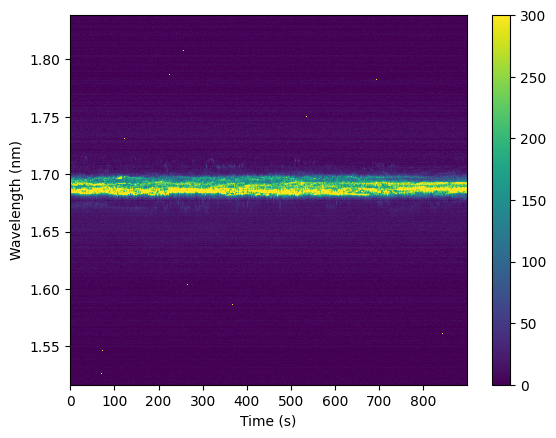

In [11]:
# plot the data as an image

wave=np.array(columns)
phot=df_as_np
time=np.array(df.index, dtype=int)

plt.pcolor(time, wave, phot.T)
plt.clim(0, 300) # plot the color bar only up to values of 300 (max value is max(phot))
plt.colorbar()
plt.xlabel("Time (s)")
plt.ylabel("Wavelength (nm)")
# plt.ylim(ymax = 1.7, ymin=1.68)
# plt.yticks(ticks=df_as_np[:,100], label=test)
# save the plot
# plt.savefig(path + 'raw_image.png',dpi=300, bbox_inches='tight', facecolor=(1, 1, 1))
# plt.close(fig)

In [12]:
### define a function to build the model

def pred_model(X_train_norm,Y_train_norm, learning_rate=0.0001, batch_size=1):

    # batch_size=math.gcd(X_train_norm.shape[0], X_val_norm.shape[0])

    model=Sequential()
    model.add(LSTM(128,batch_input_shape=(batch_size,X_train_norm.shape[1],X_train_norm.shape[2]), return_sequences=False, stateful=True))
    model.add(Dense(20, 'relu'))
    model.add(Dense(Y_train_norm.shape[1]))
    model.summary()

    # train the model
    # cp2=ModelCheckpoint('model/group/overlapnum2' , save_best_only=True) # it saves the best model based on val error
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
    return model

In [13]:
# define a function to calculate the rmse 

def pred_rmse (model, X_test_norm, Y_test, X_train): # X_test is norm, whereas Y_test and X_train are NOT norm
    predictions = model.predict(X_test_norm, batch_size=batch_size)
    predictions_actual=postprocess(predictions, X_train)
  
    return mse(Y_test, predictions_actual, squared=False) # when squared is set to false, it reteurn rmse instead of mse

In [14]:
def preprocess(X, X_train):   
    X_mean = np.mean(X_train)
    X_std = np.std(X_train)
    
    X_norm = (X - X_mean)/ X_std
    return X_norm

# Now convert the data back to before normalization
def postprocess(pred, X_train):
    
    X_mean = np.mean(X_train)
    X_std = np.std(X_train)
    
    actual = (pred * X_std) + X_mean
    return actual

#### Multivariate Predcition over all the data 

In [ ]:
# Define a function to convert the data to inputs and labels pairs (X and Y), considering all the features as a variate

def df_to_X_Y_multi(df, window_size): # input is numpy array. window size is time steps of inputs 
    df_as_np=df.to_numpy()
    X=[] # make an empty list
    y=[]
    
    for i in range(df_as_np.shape[0] -window_size): #defining a window over time
        row=[a for a in df_as_np[i:i+window_size,:]] # pick only the first feature
        X.append(row)
        label=df_as_np[i+window_size, :]
        y.append(label)
       
    return np.array(X), np.array(y) 

X_multi , Y_multi= df_to_X_Y_multi(df, window_size=5) 

X_train_multi, Y_train_multi = X_multi[:int(.8 * X_multi.shape[0])], Y_multi[:int(.8 * X_multi.shape[0])]
X_val_multi , Y_val_multi = X_multi[int(.8 * X_multi.shape[0]):int(.9 * X_multi.shape[0])] , Y_multi[int(.8 * X_multi.shape[0]):int(.9 * X_multi.shape[0])]
X_test_multi , Y_test_multi = X_multi[int(.9 * X_multi.shape[0]):] , Y_multi[int(.9 * X_multi.shape[0]):]
# X_train.shape , y_train.shape , X_val.shape , y_val.shape , X_test.shape , y_test.shape


# apply the preprocess to the inputs and outputs
X_train_multi_norm=preprocess(X_train_multi, X_train_multi)
X_val_multi_norm=preprocess(X_val_multi, X_train_multi)
X_test_multi_norm=preprocess(X_test_multi, X_train_multi)

Y_train_multi_norm=preprocess(Y_train_multi,X_train_multi)
Y_val_multi_norm=preprocess(Y_val_multi,X_train_multi)
Y_test_multi_norm=preprocess(Y_test_multi,X_train_multi)

X_train_multi_norm.shape , Y_train_multi_norm.shape , X_val_multi_norm.shape , Y_val_multi_norm.shape , X_test_multi_norm.shape , Y_test_multi_norm.shape


In [ ]:
# #change the directory for saving the model
code_path='./QE_Forecast_SecondSeries'
os.chdir(code_path)
os.getcwd()

In [ ]:
cp_multi=ModelCheckpoint('model/multivariate/time_series_11/' , save_best_only=True) # it saves the best model based on val error
model_multi=pred_model( X_train_norm=X_train_multi_norm, Y_train_norm=Y_train_multi_norm, batch_size=1)
# model_multi.fit(X_train_multi_norm, Y_train_multi_norm, validation_data=(X_val_multi_norm, Y_val_multi_norm), batch_size=1, epochs=220)
model_multi.fit(X_train_multi_norm, Y_train_multi_norm, validation_data=(X_val_multi_norm, Y_val_multi_norm), batch_size=1, epochs=200, callbacks=[cp_multi])

In [ ]:
np.where(df_as_np == df_as_np.max()), df.columns[725]

In [ ]:
# load the trained model
# model_multi=tf.keras.models.load_model('model/multivariate/time_series_11/')
batch_size=1
# predict individual wavelengths
predictions_multi = model_multi.predict(X_test_multi_norm, batch_size=1)
predictions_actual_multi=postprocess(predictions_multi, X_train_multi)

#get the column index of a specific wavelength
column_index = df.columns.get_loc(1.6893572550415243)

w=column_index
plt.plot(predictions_actual_multi[:,w], c='r', label='Predictions')
plt.plot(Y_test_multi[:,w], label= 'Actual values')   
plt.xlabel("Time (steps of 2 seconds)")
plt.ylabel("Number of Photons")
plt.title("Predcitions for wavelenght " + str(df.columns[w]))
#find the max(min) between the max(min) of predcitions and y actual as the boundary limits for plot
plt.ylim(ymax = max(np.amax(predictions_actual_multi[:,w]), np.amax(Y_test_multi[:,w]))+10, ymin =min(np.amin(predictions_actual_multi[:,w]),np.amin(Y_test_multi[:,w]))-10)
plt.legend() # so the label shows up

# return total rmse
rmse_multi=pred_rmse (model=model_multi, X_test_norm=X_test_multi_norm, Y_test=Y_test_multi, X_train=X_train_multi)
print("Total rmse over test set for all wavelenghts in multivariate model is :" + str(rmse_multi))

In [ ]:
# load the trained model
# model_multi=tf.keras.models.load_model('model/multivariate/time_series_11/')
batch_size=1
# predict individual wavelengths
predictions_multi = model_multi.predict(X_train_multi_norm, batch_size=1)
predictions_actual_multi=postprocess(predictions_multi, X_train_multi)

#get the column index of a specific wavelength
column_index = df.columns.get_loc(1.6893572550415243)

w=column_index
plt.plot(predictions_actual_multi[:,w], c='r', label='Predictions')
plt.plot(Y_train_multi[:,w], label= 'Actual values')   
plt.xlabel("Time (steps of 2 seconds)")
plt.ylabel("Number of Photons")
plt.title("Predcitions for wavelenght " + str(df.columns[w]))
#find the max(min) between the max(min) of predcitions and y actual as the boundary limits for plot
plt.ylim(ymax = max(np.amax(predictions_actual_multi[:,w]), np.amax(Y_test_multi[:,w]))+10, ymin =min(np.amin(predictions_actual_multi[:,w]),np.amin(Y_test_multi[:,w]))-10)
plt.xlim(xmin=600, xmax=800)
plt.legend() # so the label shows up

# return total rmse
rmse_multi=pred_rmse (model=model_multi, X_test_norm=X_test_multi_norm, Y_test=Y_test_multi, X_train=X_train_multi)
print("Total rmse over test set for all wavelenghts in multivariate model is :" + str(rmse_multi))

In [ ]:
df.columns[825]

In [ ]:
np.where(predictions_actual_multi==np.amax(predictions_actual_multi))

In [ ]:
### plot the predictions and actual values as images 
## (since here is the problem of multivariate and we have each column and time, we don't need to modify wave and time much)

thresh1_multi=300
thresh2_multi=10


window_size=5

time_test_multi=np.array(df.index[int(0.9*(df_as_np.shape[0] -window_size)):df_as_np.shape[0] -window_size])
wave_test_multi=np.array(df.columns)

# shifted actual data
shifted_Y_multi=np.zeros((Y_test_multi.shape[0], Y_test_multi.shape[1]))                                 
for i in range(shifted_Y_multi.shape[0]-1):
    shifted_Y_multi[i+1,:]=Y_test_multi[i,:]
    
        
plt.subplot(1,5,1)
plt.pcolor(time_test_multi, wave_test_multi, Y_test_multi.T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
#plt.clim(0, np.amax(phot)) # plot the color bar only up to values of 3000 (max value is max(phot))
plt.clim(0,thresh1_multi)
plt.colorbar()
plt.xlabel("Time (s)")
plt.ylabel("Wavelength (nm)")
plt.title("Actual Data")
# plt.ylim(ymax = 630, ymin = 618)
#     plt.show()

plt.subplot(1,5,2)
plt.pcolor(time_test_multi, wave_test_multi, predictions_actual_multi.T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
#plt.clim(0, np.amax(phot)) # plot the color bar only up to values of 3000 (max value is max(phot))
plt.clim(0,thresh1_multi)
plt.colorbar()
plt.xlabel("Time (s)")
#     plt.ylabel("Wavelength (nm)")
plt.yticks([])   # hide the y ticks
plt.title("LSTM Forecast")
# plt.ylim(ymax = 630, ymin = 618)
#     plt.show()

plt.subplot(1,5,3)
plt.pcolor(time_test_multi, wave_test_multi, shifted_Y_multi.T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
#plt.clim(0, np.amax(phot)) # plot the color bar only up to values of 3000 (max value is max(phot))
plt.clim(0,thresh1_multi)
plt.colorbar()
plt.xlabel("Time (s)")
#     plt.ylabel("Wavelength (nm)")
plt.yticks([])   # hide the y ticks
plt.title("Shifted Forecast")
# plt.ylim(ymax = 630, ymin = 618)
#     plt.show()

#plot the abs difference of the actual data and predcited data
plt.subplot(1,5,4)
plt.pcolor(time_test_multi, wave_test_multi, (abs(Y_test_multi-predictions_actual_multi)).T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
plt.clim(0,thresh2_multi)
plt.colorbar()
plt.xlabel("Time (s)")
#     plt.ylabel("Wavelength (nm)")
plt.yticks([])   # hide the y ticks
plt.title("LSTM Difference")

#plot the abs difference of the actual data and the shifted data
plt.subplot(1,5,5)
plt.pcolor(time_test_multi, wave_test_multi, (abs(Y_test_multi-shifted_Y_multi)).T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
plt.clim(0,thresh2_multi)
plt.colorbar()
plt.xlabel("Time (s)")
#     plt.ylabel("Wavelength (nm)")
plt.yticks([])   # hide the y ticks
plt.title("Shifted Difference")

plt.subplots_adjust(wspace=0.2, hspace=0.6, left=0.01, top=0.8, right=2)  
# save the images
# plt.savefig(path + 'multi_images.png',dpi=300, bbox_inches='tight', facecolor=(1, 1, 1))
# rmse1=mse(Y_test_multi, predictions_actual_multi, squared=False)
rmse2=mse(Y_test_multi, shifted_Y_multi, squared=False)

print("Total rmse over test set using prediction model is :" + str(rmse_multi))
print("Total rmse over test set using shifted model is :" + str(rmse2))    




In [ ]:
#### Calculating the rmse corresponding to the wavevelghts within each band, considering the first model

In [ ]:
# # band1:
# y_multi_band1=Y_test_multi[:,ss_band1:ee_band1]
# y_multi_band1_predict=predictions_actual_multi[:,ss_band1:ee_band1]
# band1_multi_rmse=mse(y_multi_band1, y_multi_band1_predict, squared=False)

# y_multi_band2=Y_test_multi[:,ss_band2:ee_band2]
# y_multi_band2_predict=predictions_actual_multi[:,ss_band2:ee_band2]
# band2_multi_rmse=mse(y_multi_band2, y_multi_band2_predict, squared=False)

# y_multi_band3=Y_test_multi[:,ss_band3:ee_band3]
# y_multi_band3_predict=predictions_actual_multi[:,ss_band3:ee_band3]
# band3_multi_rmse=mse(y_multi_band3, y_multi_band3_predict, squared=False)

# y_multi_band4=Y_test_multi[:,ss_band4:ee_band4]
# y_multi_band4_predict=predictions_actual_multi[:,ss_band4:ee_band4]
# band4_multi_rmse=mse(y_multi_band4, y_multi_band4_predict, squared=False)

# print(band1_multi_rmse), print(band2_multi_rmse), print(band3_multi_rmse), print(band4_multi_rmse)

#### Multivariate predcitions for four bands (meaning considering all wavelength in the band)

In [15]:
# Define a function to convert the data to inputs and labels pairs (X and Y), considering a band of wavelengths

def df_to_X_Y_band(df, window_size, ss=100, ee=128): 
    df_as_np=df.iloc[:,ss:ee].to_numpy()
    X=[] # make an empty list
    Y=[]
    for i in range(len(df_as_np)-window_size): # there is overlap between windows in time.
        row=[a for a in df_as_np[i:i+window_size]] # we write the for loop to make every variable in a []. Here we consider all the features as input
        X.append(row)

        label=df_as_np[i+window_size] # predict only one feature (col)
        Y.append(label)
        
    X=np.array(X)
    Y=np.array(Y)
    
    window_size=5

    X_band , Y_band= X, Y
    # Split the data to train, val and test by 80,10 and 10% of the data
    X_train_band, Y_train_band = X_band[:int(.8 * X_band.shape[0])-1], Y_band[:int(.8 * X_band.shape[0]-1)]
    X_val_band , Y_val_band = X_band[int(.8 * X_band.shape[0]-2):int(.9 * X_band.shape[0])] , Y_band[int(.8 * X_band.shape[0])-2:int(.9 * X_band.shape[0])]
    X_test_band , Y_test_band = X_band[int(.9 * X_band.shape[0]):] , Y_band[int(.9 * X_band.shape[0]):]
#     X_train_band.shape , Y_train_band.shape , X_val_band.shape , Y_val_band.shape , X_test_band.shape , Y_test_band.shape

    # apply the preprocess to the inputs and outputs
    X_train_band_norm=preprocess(X_train_band, X_train_band)
    X_val_band_norm=preprocess(X_val_band, X_train_band)
    X_test_band_norm=preprocess(X_test_band, X_train_band)

    Y_train_band_norm=preprocess(Y_train_band,X_train_band)
    Y_val_band_norm=preprocess(Y_val_band,X_train_band)
    Y_test_band_norm=preprocess(Y_test_band,X_train_band)

    return X_train_band_norm , Y_train_band_norm , X_val_band_norm , Y_val_band_norm , X_test_band_norm , Y_test_band_norm, Y_test_band, X_train_band, Y_train_band


In [16]:
# Plot function and calculate rmse

from sklearn.metrics import mean_squared_error as mse
def plot_predictions_band(model_band, X_test_band_norm, X_train_band, Y_test_band, start=0, end=20, ss=100, ee=128, wave_to_save=2):
#     predictions=  model.predict(X_norm[start:end], batch_size=batch_size)
#     predictions_actual=postprocess(predictions,  X_train_band1)
#     Y_actual=postprocess(Y[start:end],  X_norm_train_band1) 
    predictions_band = model_band.predict(X_test_band_norm, batch_size=batch_size)
    predictions_actual_band=postprocess(predictions_band, X_train_band)
    
    plt.figure(figsize = (10,8)) # with this, you can change the size of each image
    
    num_wave=predictions_actual_band.shape[1]
    
#     for i in range(num_wave):
    for i in range(20):
        
        plt.subplot(10, 2, i+1)
#         plt.subplot(50, 2, i+1) # #the figure has 10 row, 3 columns, and this plot is the first plot.
        plt.plot(predictions_actual_band[:,i], c='r', label='Predictions for ' + str(df.iloc[:,ss:ee].columns[i]) + ' wavelength')
        plt.plot(Y_test_band[:,i], label= 'Actual values')   
        plt.xlabel("Time (steps of 2 seconds)")
        plt.ylabel("Number of Photons")
        #find the maX_norm(min) between the maX_norm(min) of predcitions and y actual as the boundary limits for plot
        plt.ylim(ymax = max(np.amax(predictions_actual_band[:,i]), np.amax(Y_test_band[:,i]))+20, ymin =min(np.amin(predictions_actual_band[:,i]),np.amin(Y_test_band[:,i]))-20)
        plt.legend() # so the label shows up

    plt.subplots_adjust(wspace=0.3, hspace=0.7, left=0.01, top=9, right=1.4)   
    total_rmse=mse(Y_test_band, predictions_actual_band, squared=False)
#     # save a specific plot for lstm prediction as well as shifted prediction
    
#     # shifted actual data
#     shifted=np.zeros((Y_test_band[:,wave_to_save].shape[0], 1))                                 
#     for n in range(shifted.shape[0]-1):
#         shifted[n+1,:]=Y_test_band[:,wave_to_save][n]
    
    
#     fig = plt.figure()
#     plt.plot(Y_test_band[:,wave_to_save], 'k', label= 'Actual Data') 
#     plt.plot(predictions_actual_band[:,wave_to_save], color='blue',linestyle='dashed', label='LSTM Forecast')
#     plt.plot(shifted,color='orange', linestyle='dashed', label='Shifted Forecast')
#     plt.title('Prediction for λ = ' + str(df.iloc[:,ss:ee].columns[wave_to_save]) + ' nm')
#     plt.xlabel("Time (steps of 2 seconds)")
#     plt.ylabel("Number of Photons")
#     #find the maX_norm(min) between the maX_norm(min) of predcitions and y actual as the boundary limits for plot
#     plt.ylim(ymax = max(np.amax(predictions_actual_band[:,wave_to_save]), np.amax(Y_test_band[:,wave_to_save]))+20, ymin =min(np.amin(predictions_actual_band[:,wave_to_save]),np.amin(Y_test_band[:,wave_to_save]))-20)
#     plt.legend() # so the label shows up
# #     plt.savefig(path + str(df.iloc[:,ss:ee].columns[wave_to_save]) + '.png',dpi=300, bbox_inches='tight', facecolor=(1, 1, 1))
#     plt.close(fig)
#     lstm_rmse_wave_to_save=mse(Y_test_band[:,wave_to_save],predictions_actual_band[:,wave_to_save], squared=False)
#     shift_rmse_wave_to_save=mse(Y_test_band[:,wave_to_save], shifted, squared=False )
#     print("LSTM rmse for " + str(df.iloc[:,ss:ee].columns[wave_to_save]) + " is: "+ str(lstm_rmse_wave_to_save))
#     print("Shifted rmse for " + str(df.iloc[:,ss:ee].columns[wave_to_save]) + " is: "+ str(shift_rmse_wave_to_save))
    
          
    print("Total rmse over test set using prediction model is :" + str(total_rmse))
#     return mse(Y_test_band, predictions_actual_band, squared=False)# when squared is set to false, it reteurn rmse instead of mse


In [17]:
### plot the predictions and actual values as images 

def band_image(model_band, X_test_band_norm, Y_test_band, X_train_band, df_as_np, window_size, ss=100, ee=128, thresh1=3000, thresh2=500):
    
    
    #predict
    predictions_band = model_band.predict(X_test_band_norm, batch_size=batch_size)
    predictions_actual_band=postprocess(predictions_band, X_train_band)

    window_size=5

    time_test_band=np.array(df.index[int(0.9*(df_as_np.shape[0] -window_size)):df_as_np.shape[0] -window_size])
    wave_test_band=np.array(df.columns[ss:ee])
   
    # shifted actual data
    shifted_Y=np.zeros((Y_test_band.shape[0], Y_test_band.shape[1]))                                 
    for i in range(shifted_Y.shape[0]-1):
        shifted_Y[i+1,:]=Y_test_band[i,:]

    plt.subplot(1,5,1)
    plt.pcolor(time_test_band, wave_test_band, Y_test_band.T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
    #plt.clim(0, np.amax(phot)) # plot the color bar only up to values of 3000 (max value is max(phot))
    plt.clim(0,thresh1)
    plt.colorbar()
    plt.xlabel("Time (s)")
    plt.ylabel("Wavelength (nm)")
    plt.title("Actual Data")
    # plt.ylim(ymax = 630, ymin = 618)
#     plt.show()

    plt.subplot(1,5,2)
    plt.pcolor(time_test_band, wave_test_band, predictions_actual_band.T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
    #plt.clim(0, np.amax(phot)) # plot the color bar only up to values of 3000 (max value is max(phot))
    plt.clim(0,thresh1)
    plt.colorbar()
    plt.xlabel("Time (s)")
#     plt.ylabel("Wavelength (nm)")
    plt.yticks([])   # hide the y ticks
    plt.title("LSTM Forecast")
    # plt.ylim(ymax = 630, ymin = 618)
#     plt.show()

    plt.subplot(1,5,3)
    plt.pcolor(time_test_band, wave_test_band, shifted_Y.T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
    #plt.clim(0, np.amax(phot)) # plot the color bar only up to values of 3000 (max value is max(phot))
    plt.clim(0,thresh1)
    plt.colorbar()
    plt.xlabel("Time (s)")
#     plt.ylabel("Wavelength (nm)")
    plt.yticks([])   # hide the y ticks
    plt.title("Shifted Forecast")
    # plt.ylim(ymax = 630, ymin = 618)
#     plt.show()

    #plot the abs difference of the actual data and predcited data
    plt.subplot(1,5,4)
    plt.pcolor(time_test_band, wave_test_band, (abs(Y_test_band-predictions_actual_band)).T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
    plt.clim(0,thresh2)
    plt.colorbar()
    plt.xlabel("Time (s)")
#     plt.ylabel("Wavelength (nm)")
    plt.yticks([])   # hide the y ticks
    plt.title("LSTM Difference")
    
    #plot the abs difference of the actual data and the shifted data
    plt.subplot(1,5,5)
    plt.pcolor(time_test_band, wave_test_band, (abs(Y_test_band-shifted_Y)).T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
    plt.clim(0,thresh2)
    plt.colorbar()
    plt.xlabel("Time (s)")
#     plt.ylabel("Wavelength (nm)")
    plt.yticks([])   # hide the y ticks
    plt.title("Shifted Difference")
      
    plt.subplots_adjust(wspace=0.2, hspace=0.6, left=0.01, top=0.8, right=2)  
    
    rmse1=mse(Y_test_band, predictions_actual_band, squared=False)
    rmse2=mse(Y_test_band, shifted_Y, squared=False)
    
    print("Total rmse over test set using prediction model is :" + str(rmse1))
    print("Total rmse over test set using shifted model is :" + str(rmse2))
    

In [18]:
### calculate and plot the correlation matrix for a group of the features

import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

def corr_auto(df, ss_band, ee_band, lags, fig_name, ticks):
    
    df_small = df.iloc[:,ss_band:ee_band]
    
    # get correlation
    correlation_mat = df_small.corr()
    mat_plot=sns.heatmap(correlation_mat, annot = False, xticklabels=ticks, yticklabels=ticks, square=False) # xticklabels define the number of ticks on x axis. by default it is auto and shows all the ticks
#     mat_plot.set_xlim(0,40)
    fig = mat_plot.get_figure()
#     plt.savefig(path + fig_name + 'corr'+'.png', dpi=300, bbox_inches='tight', facecolor=(1, 1, 1)) # facecolor is used to set the background to white, so we can see the axes in the saved image (otherwise it's black)
    plt.show()
    
    # plot autocorrelation for the wavelegth at the center of the band
    center=int((ee_band - ss_band)/2)
    plot_acf(df_small.iloc[:,center], lags=lags)
    print("Autocorrelation for " + str(df_small.columns[center]) + " for " + str(lags) + " lags")
#     plt.savefig(path + fig_name + 'autocorr'+'.png', dpi=300, bbox_inches='tight', facecolor=(1, 1, 1)) # facecolor is used to set the background to white, so we can see the axes in the saved image (otherwise it's black)
    plt.show()
    
    
    
## we can also use numpy for plot
# plt.matshow(df.iloc[:,ss_band1:ee_band1].corr())
# plt.show()

#### Band1

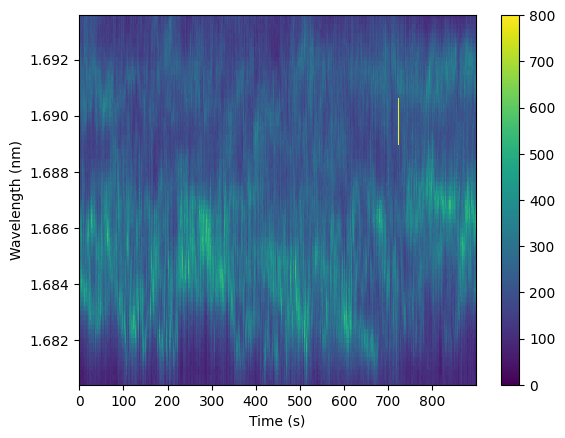

In [61]:
### Pick the first band and apply muti variate to them
# plot the data as an image for a range of wave
df_as_np=df.to_numpy(dtype=np.single)

wave=np.array(df.columns)
phot=df_as_np
time=np.array(df.index, dtype=int)

ss_band1=800
ee_band1=880

plt.pcolor(time, wave[ss_band1:ee_band1], phot.T[ss_band1:ee_band1])
plt.clim(0, 800) # plot the color bar only up to values of 3000 (max value is max(phot))
plt.colorbar()
plt.xlabel("Time (s)")
plt.ylabel("Wavelength (nm)")
# plt.ylim(ymax = 630, ymin = 618)
plt.show()

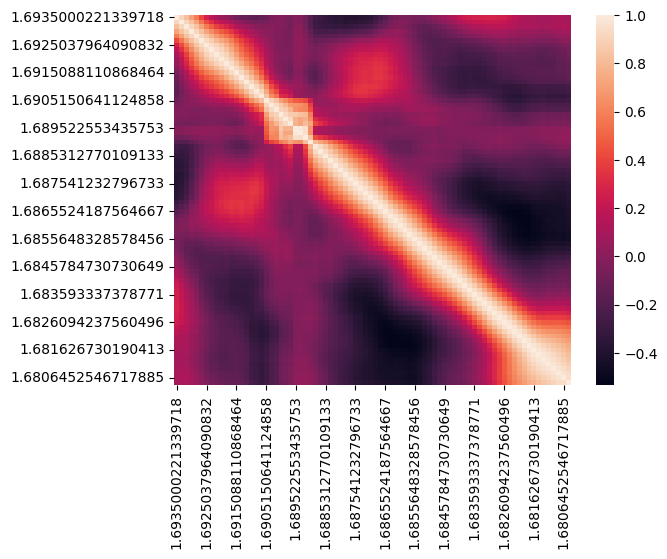

Autocorrelation for 1.6868818868761057 for 100 lags


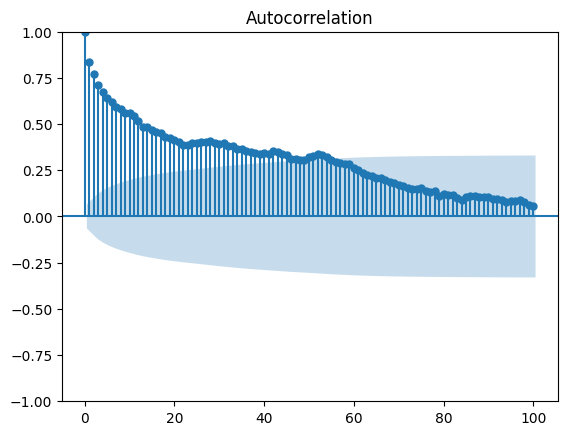

In [58]:
# plot correlation matrix as well as the autocorrelation for the middle wavelegths for band1
corr_auto(df, ss_band1, ee_band1, lags=100, fig_name='band1', ticks=6)

In [26]:
X_train_band1_norm , Y_train_band1_norm , X_val_band1_norm , Y_val_band1_norm , X_test_band1_norm , Y_test_band1_norm, Y_test_band1, X_train_band1, Y_train_band1=df_to_X_Y_band(df, window_size=5, ss=ss_band1, ee=ee_band1)
X_train_band1_norm.shape , Y_train_band1_norm.shape , X_val_band1_norm.shape , Y_val_band1_norm.shape , X_test_band1_norm.shape , Y_test_band1_norm.shape,  Y_train_band1.shape

((715, 5, 80),
 (715, 80),
 (91, 5, 80),
 (91, 80),
 (90, 5, 80),
 (90, 80),
 (715, 80))

In [27]:
# model/multivariate/time_series_11/'
cp_band1=ModelCheckpoint('/model/multivariate/time_series_11/band/band1/' , save_best_only=True) # it saves the best model based on val error
model_band1=pred_model(X_train_band1_norm, Y_train_band1_norm, learning_rate=0.0001, batch_size=1)
# model_band1.fit(X_train_band1_norm, Y_train_band1_norm, validation_data=(X_val_band1_norm, Y_val_band1_norm), batch_size=1, epochs=50)
model_band1.fit(X_train_band1_norm, Y_train_band1_norm, validation_data=(X_val_band1_norm, Y_val_band1_norm), batch_size=1, epochs=300, callbacks=[cp_band1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 128)                  107008    
                                                                 
 dense (Dense)               (1, 20)                   2580      
                                                                 
 dense_1 (Dense)             (1, 80)                   1680      
                                                                 
Total params: 111,268
Trainable params: 111,268
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
714/715 [============================>.] - ETA: 0s - loss: 0.7244 - root_mean_squared_error: 0.8511

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


715/715 [==============================] - 14s 17ms/step - loss: 0.7238 - root_mean_squared_error: 0.8508 - val_loss: 1.7272 - val_root_mean_squared_error: 1.3142
Epoch 2/300
709/715 [============================>.] - ETA: 0s - loss: 0.4362 - root_mean_squared_error: 0.6605

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


715/715 [==============================] - 12s 17ms/step - loss: 0.4358 - root_mean_squared_error: 0.6601 - val_loss: 1.6832 - val_root_mean_squared_error: 1.2974
Epoch 3/300
714/715 [============================>.] - ETA: 0s - loss: 0.3769 - root_mean_squared_error: 0.6139

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


715/715 [==============================] - 11s 16ms/step - loss: 0.3767 - root_mean_squared_error: 0.6137 - val_loss: 1.6375 - val_root_mean_squared_error: 1.2796
Epoch 4/300
711/715 [============================>.] - ETA: 0s - loss: 0.3410 - root_mean_squared_error: 0.5840

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


715/715 [==============================] - 12s 17ms/step - loss: 0.3409 - root_mean_squared_error: 0.5838 - val_loss: 1.6192 - val_root_mean_squared_error: 1.2725
Epoch 5/300
705/715 [============================>.] - ETA: 0s - loss: 0.3193 - root_mean_squared_error: 0.5650

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


715/715 [==============================] - 11s 16ms/step - loss: 0.3189 - root_mean_squared_error: 0.5647 - val_loss: 1.5981 - val_root_mean_squared_error: 1.2642
Epoch 6/300
704/715 [============================>.] - ETA: 0s - loss: 0.3047 - root_mean_squared_error: 0.5520

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


715/715 [==============================] - 12s 17ms/step - loss: 0.3037 - root_mean_squared_error: 0.5511 - val_loss: 1.5979 - val_root_mean_squared_error: 1.2641
Epoch 7/300
707/715 [============================>.] - ETA: 0s - loss: 0.2920 - root_mean_squared_error: 0.5404

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


715/715 [==============================] - 11s 15ms/step - loss: 0.2919 - root_mean_squared_error: 0.5403 - val_loss: 1.5944 - val_root_mean_squared_error: 1.2627
Epoch 8/300
708/715 [============================>.] - ETA: 0s - loss: 0.2840 - root_mean_squared_error: 0.5329

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


715/715 [==============================] - 12s 17ms/step - loss: 0.2832 - root_mean_squared_error: 0.5322 - val_loss: 1.5883 - val_root_mean_squared_error: 1.2603
Epoch 9/300
715/715 [==============================] - 3s 5ms/step - loss: 0.2748 - root_mean_squared_error: 0.5242 - val_loss: 1.6032 - val_root_mean_squared_error: 1.2662
Epoch 10/300
715/715 [==============================] - 3s 5ms/step - loss: 0.2686 - root_mean_squared_error: 0.5182 - val_loss: 1.5959 - val_root_mean_squared_error: 1.2633
Epoch 11/300
715/715 [==============================] - 4s 5ms/step - loss: 0.2625 - root_mean_squared_error: 0.5124 - val_loss: 1.5904 - val_root_mean_squared_error: 1.2611
Epoch 12/300
715/715 [==============================] - 3s 5ms/step - loss: 0.2572 - root_mean_squared_error: 0.5072 - val_loss: 1.5900 - val_root_mean_squared_error: 1.2609
Epoch 13/300
714/715 [============================>.] - ETA: 0s - loss: 0.2516 - root_mean_squared_error: 0.5016

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


715/715 [==============================] - 12s 16ms/step - loss: 0.2515 - root_mean_squared_error: 0.5015 - val_loss: 1.5823 - val_root_mean_squared_error: 1.2579
Epoch 14/300
715/715 [==============================] - 3s 5ms/step - loss: 0.2482 - root_mean_squared_error: 0.4982 - val_loss: 1.5862 - val_root_mean_squared_error: 1.2595
Epoch 15/300
715/715 [==============================] - 4s 5ms/step - loss: 0.2435 - root_mean_squared_error: 0.4935 - val_loss: 1.5831 - val_root_mean_squared_error: 1.2582
Epoch 16/300
705/715 [============================>.] - ETA: 0s - loss: 0.2391 - root_mean_squared_error: 0.4890

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


715/715 [==============================] - 13s 18ms/step - loss: 0.2392 - root_mean_squared_error: 0.4890 - val_loss: 1.5790 - val_root_mean_squared_error: 1.2566
Epoch 17/300
715/715 [==============================] - 3s 5ms/step - loss: 0.2349 - root_mean_squared_error: 0.4846 - val_loss: 1.5850 - val_root_mean_squared_error: 1.2590
Epoch 18/300
715/715 [==============================] - ETA: 0s - loss: 0.2316 - root_mean_squared_error: 0.4812

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


715/715 [==============================] - 12s 16ms/step - loss: 0.2316 - root_mean_squared_error: 0.4812 - val_loss: 1.5747 - val_root_mean_squared_error: 1.2549
Epoch 19/300
715/715 [==============================] - 4s 6ms/step - loss: 0.2285 - root_mean_squared_error: 0.4780 - val_loss: 1.5750 - val_root_mean_squared_error: 1.2550
Epoch 20/300
715/715 [==============================] - 4s 6ms/step - loss: 0.2241 - root_mean_squared_error: 0.4734 - val_loss: 1.5872 - val_root_mean_squared_error: 1.2598
Epoch 21/300
709/715 [============================>.] - ETA: 0s - loss: 0.2214 - root_mean_squared_error: 0.4705

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


715/715 [==============================] - 12s 17ms/step - loss: 0.2210 - root_mean_squared_error: 0.4701 - val_loss: 1.5673 - val_root_mean_squared_error: 1.2519
Epoch 22/300
705/715 [============================>.] - ETA: 0s - loss: 0.2174 - root_mean_squared_error: 0.4663

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


715/715 [==============================] - 12s 17ms/step - loss: 0.2177 - root_mean_squared_error: 0.4665 - val_loss: 1.5583 - val_root_mean_squared_error: 1.2483
Epoch 23/300
715/715 [==============================] - 4s 5ms/step - loss: 0.2146 - root_mean_squared_error: 0.4632 - val_loss: 1.5615 - val_root_mean_squared_error: 1.2496
Epoch 24/300
708/715 [============================>.] - ETA: 0s - loss: 0.2112 - root_mean_squared_error: 0.4595

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


715/715 [==============================] - 13s 18ms/step - loss: 0.2113 - root_mean_squared_error: 0.4597 - val_loss: 1.5539 - val_root_mean_squared_error: 1.2465
Epoch 25/300
713/715 [============================>.] - ETA: 0s - loss: 0.2073 - root_mean_squared_error: 0.4554

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


715/715 [==============================] - 13s 18ms/step - loss: 0.2074 - root_mean_squared_error: 0.4554 - val_loss: 1.5454 - val_root_mean_squared_error: 1.2431
Epoch 26/300
715/715 [==============================] - 4s 5ms/step - loss: 0.2054 - root_mean_squared_error: 0.4532 - val_loss: 1.5485 - val_root_mean_squared_error: 1.2444
Epoch 27/300
715/715 [==============================] - 4s 5ms/step - loss: 0.2016 - root_mean_squared_error: 0.4490 - val_loss: 1.5496 - val_root_mean_squared_error: 1.2448
Epoch 28/300
704/715 [============================>.] - ETA: 0s - loss: 0.1993 - root_mean_squared_error: 0.4465

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


715/715 [==============================] - 12s 17ms/step - loss: 0.1990 - root_mean_squared_error: 0.4461 - val_loss: 1.5442 - val_root_mean_squared_error: 1.2426
Epoch 29/300
715/715 [==============================] - 4s 5ms/step - loss: 0.1970 - root_mean_squared_error: 0.4438 - val_loss: 1.5526 - val_root_mean_squared_error: 1.2460
Epoch 30/300
715/715 [==============================] - 4s 5ms/step - loss: 0.1944 - root_mean_squared_error: 0.4409 - val_loss: 1.5521 - val_root_mean_squared_error: 1.2458
Epoch 31/300
715/715 [==============================] - 4s 6ms/step - loss: 0.1912 - root_mean_squared_error: 0.4372 - val_loss: 1.5468 - val_root_mean_squared_error: 1.2437
Epoch 32/300
715/715 [==============================] - 4s 6ms/step - loss: 0.1890 - root_mean_squared_error: 0.4348 - val_loss: 1.5480 - val_root_mean_squared_error: 1.2442
Epoch 33/300
706/715 [============================>.] - ETA: 0s - loss: 0.1864 - root_mean_squared_error: 0.4317

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band1\assets


715/715 [==============================] - 14s 19ms/step - loss: 0.1861 - root_mean_squared_error: 0.4314 - val_loss: 1.5440 - val_root_mean_squared_error: 1.2426
Epoch 34/300
715/715 [==============================] - 4s 6ms/step - loss: 0.1835 - root_mean_squared_error: 0.4283 - val_loss: 1.5454 - val_root_mean_squared_error: 1.2431
Epoch 35/300
715/715 [==============================] - 4s 6ms/step - loss: 0.1813 - root_mean_squared_error: 0.4258 - val_loss: 1.5496 - val_root_mean_squared_error: 1.2448
Epoch 36/300
715/715 [==============================] - 4s 6ms/step - loss: 0.1787 - root_mean_squared_error: 0.4227 - val_loss: 1.5496 - val_root_mean_squared_error: 1.2448
Epoch 37/300
715/715 [==============================] - 8s 11ms/step - loss: 0.1777 - root_mean_squared_error: 0.4215 - val_loss: 1.5463 - val_root_mean_squared_error: 1.2435
Epoch 38/300
715/715 [==============================] - 5s 7ms/step - loss: 0.1750 - root_mean_squared_error: 0.4184 - val_loss: 1.5537 - va

Epoch 127/300
715/715 [==============================] - 5s 7ms/step - loss: 0.0682 - root_mean_squared_error: 0.2612 - val_loss: 1.8712 - val_root_mean_squared_error: 1.3679
Epoch 128/300
715/715 [==============================] - 12s 17ms/step - loss: 0.0676 - root_mean_squared_error: 0.2600 - val_loss: 1.8700 - val_root_mean_squared_error: 1.3675
Epoch 129/300
715/715 [==============================] - 5s 8ms/step - loss: 0.0669 - root_mean_squared_error: 0.2586 - val_loss: 1.8760 - val_root_mean_squared_error: 1.3697
Epoch 130/300
715/715 [==============================] - 5s 7ms/step - loss: 0.0670 - root_mean_squared_error: 0.2589 - val_loss: 1.8893 - val_root_mean_squared_error: 1.3745
Epoch 131/300
715/715 [==============================] - 4s 6ms/step - loss: 0.0661 - root_mean_squared_error: 0.2571 - val_loss: 1.8586 - val_root_mean_squared_error: 1.3633
Epoch 132/300
715/715 [==============================] - 4s 6ms/step - loss: 0.0650 - root_mean_squared_error: 0.2550 - val

Epoch 174/300
715/715 [==============================] - 4s 6ms/step - loss: 0.0466 - root_mean_squared_error: 0.2160 - val_loss: 1.9271 - val_root_mean_squared_error: 1.3882
Epoch 175/300
715/715 [==============================] - 4s 6ms/step - loss: 0.0465 - root_mean_squared_error: 0.2156 - val_loss: 1.9653 - val_root_mean_squared_error: 1.4019
Epoch 176/300
715/715 [==============================] - 4s 5ms/step - loss: 0.0459 - root_mean_squared_error: 0.2142 - val_loss: 1.9444 - val_root_mean_squared_error: 1.3944
Epoch 177/300
715/715 [==============================] - 5s 7ms/step - loss: 0.0458 - root_mean_squared_error: 0.2139 - val_loss: 1.9526 - val_root_mean_squared_error: 1.3973
Epoch 178/300
715/715 [==============================] - 13s 18ms/step - loss: 0.0452 - root_mean_squared_error: 0.2127 - val_loss: 1.9437 - val_root_mean_squared_error: 1.3942
Epoch 179/300
715/715 [==============================] - 5s 8ms/step - loss: 0.0451 - root_mean_squared_error: 0.2125 - val

Epoch 221/300
715/715 [==============================] - 4s 5ms/step - loss: 0.0354 - root_mean_squared_error: 0.1881 - val_loss: 1.8976 - val_root_mean_squared_error: 1.3775
Epoch 222/300
715/715 [==============================] - 4s 6ms/step - loss: 0.0352 - root_mean_squared_error: 0.1876 - val_loss: 1.9204 - val_root_mean_squared_error: 1.3858
Epoch 223/300
715/715 [==============================] - 4s 6ms/step - loss: 0.0349 - root_mean_squared_error: 0.1869 - val_loss: 1.8998 - val_root_mean_squared_error: 1.3783
Epoch 224/300
715/715 [==============================] - 4s 5ms/step - loss: 0.0349 - root_mean_squared_error: 0.1869 - val_loss: 1.9048 - val_root_mean_squared_error: 1.3802
Epoch 225/300
715/715 [==============================] - 6s 8ms/step - loss: 0.0347 - root_mean_squared_error: 0.1862 - val_loss: 1.8813 - val_root_mean_squared_error: 1.3716
Epoch 226/300
715/715 [==============================] - 5s 7ms/step - loss: 0.0344 - root_mean_squared_error: 0.1856 - val_l

Epoch 268/300
715/715 [==============================] - 5s 7ms/step - loss: 0.0290 - root_mean_squared_error: 0.1702 - val_loss: 1.8722 - val_root_mean_squared_error: 1.3683
Epoch 269/300
715/715 [==============================] - 6s 8ms/step - loss: 0.0290 - root_mean_squared_error: 0.1704 - val_loss: 1.8729 - val_root_mean_squared_error: 1.3686
Epoch 270/300
715/715 [==============================] - 4s 5ms/step - loss: 0.0287 - root_mean_squared_error: 0.1693 - val_loss: 1.8857 - val_root_mean_squared_error: 1.3732
Epoch 271/300
715/715 [==============================] - 5s 6ms/step - loss: 0.0286 - root_mean_squared_error: 0.1692 - val_loss: 1.8636 - val_root_mean_squared_error: 1.3651
Epoch 272/300
715/715 [==============================] - 5s 7ms/step - loss: 0.0286 - root_mean_squared_error: 0.1690 - val_loss: 1.8650 - val_root_mean_squared_error: 1.3657
Epoch 273/300
715/715 [==============================] - 4s 6ms/step - loss: 0.0285 - root_mean_squared_error: 0.1687 - val_l

In [28]:
batch_size=1

90/90 [==============================] - 1s 3ms/step
Total rmse over test set using prediction model is :66.03565396200642


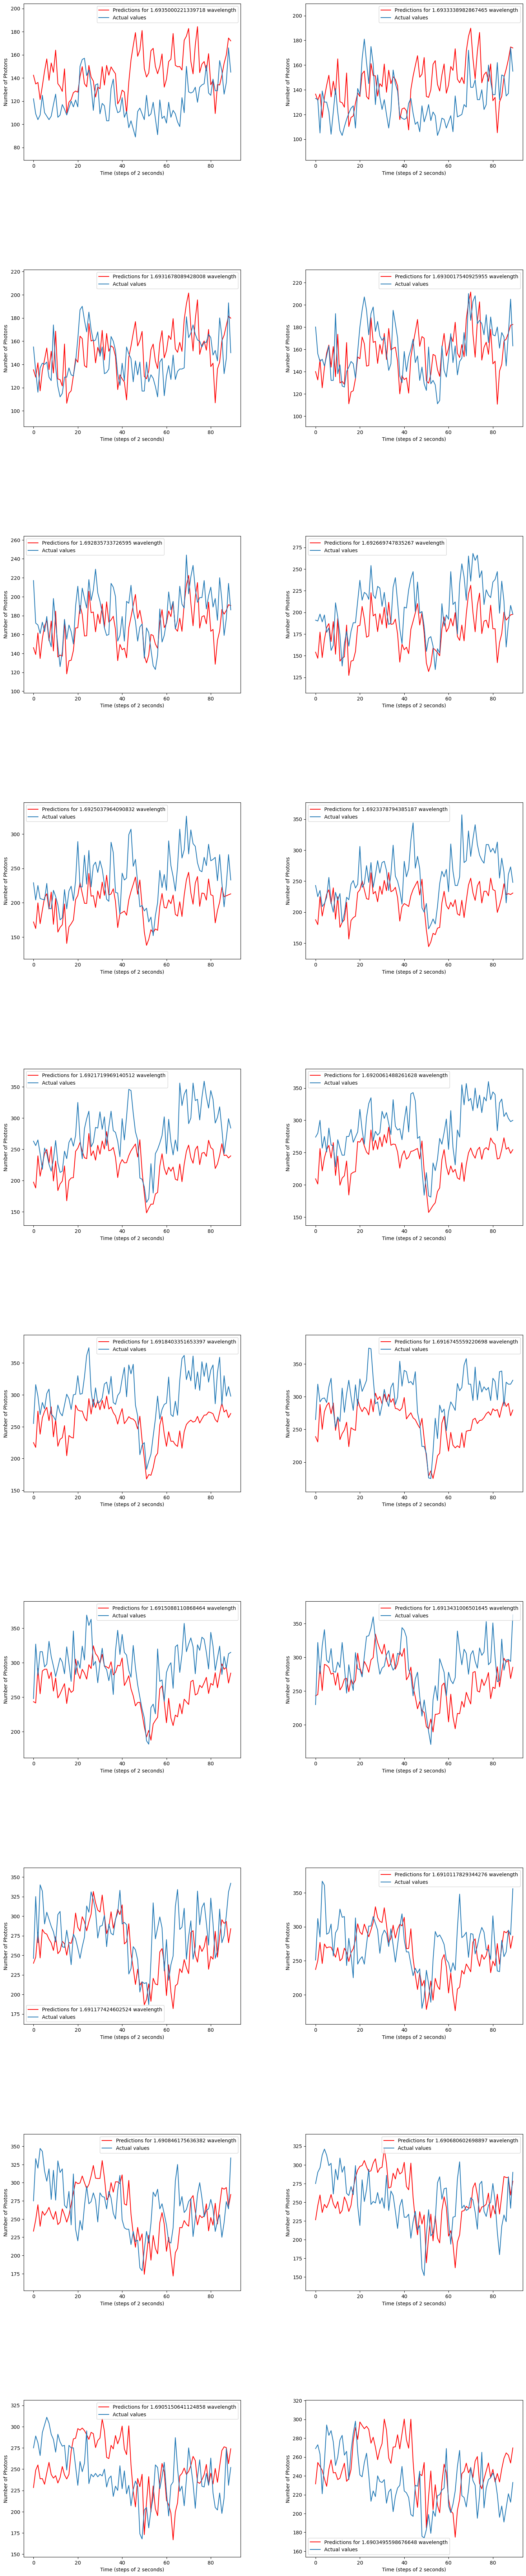

In [29]:
### plot the predictions and actual values 
# load the trained model
# model_band1=tf.keras.models.load_model('model/publish/band/band1/')

plot_predictions_band(model_band=model_band1, X_test_band_norm=X_test_band1_norm, X_train_band=X_train_band1, Y_test_band=Y_test_band1, start=0, end=20 ,ss=ss_band1, ee=ee_band1)

In [24]:
# plot_predictions_band(model_band=model_band1, X_test_band_norm=X_train_band1_norm, X_train_band=X_train_band1, Y_test_band=Y_train_band1, start=0, end=20 ,ss=ss_band1, ee=ee_band1)

In [31]:
window_size=5

90/90 [==============================] - 0s 3ms/step
Total rmse over test set using prediction model is :66.07242411135094
Total rmse over test set using shifted model is :41.10997199001866


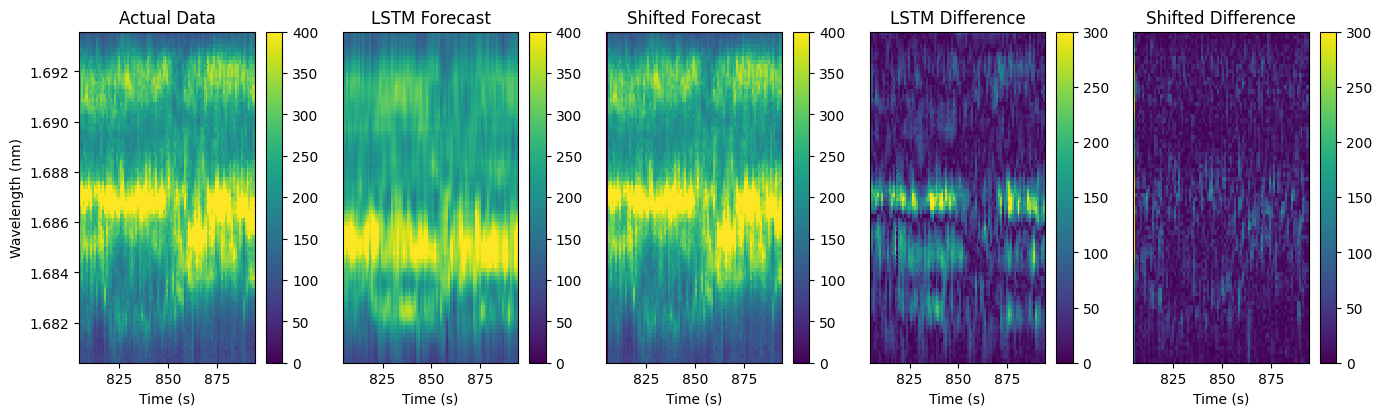

In [32]:
### plot the predictions and actual values as images 

band_image(model_band1, X_test_band1_norm, Y_test_band1, X_train_band1, df_as_np, window_size, ss=ss_band1, ee=ee_band1, thresh1=400, thresh2=300)
# save the images
# plt.savefig(path + 'band1_images.png',dpi=300, bbox_inches='tight', facecolor=(1, 1, 1))

#### Band 2

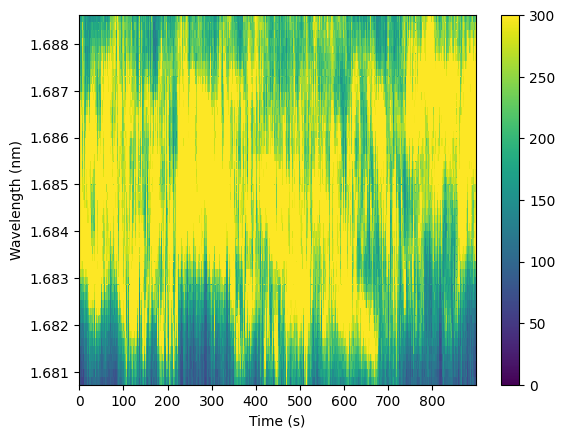

In [47]:
### Pick the first band and apply muti variate to them
# plot the data as an image for a range of wave

wave=np.array(df.columns)
phot=df_as_np
time=np.array(df.index, dtype=int)

ss_band2=830
ee_band2=878

plt.pcolor(time, wave[ss_band2:ee_band2], phot.T[ss_band2:ee_band2])
plt.clim(0, 300) # plot the color bar only up to values of 3000 (max value is np.amax(phot))
plt.colorbar()
plt.xlabel("Time (s)")
plt.ylabel("Wavelength (nm)")
# plt.ylim(ymax = 630, ymin = 618)
plt.show()

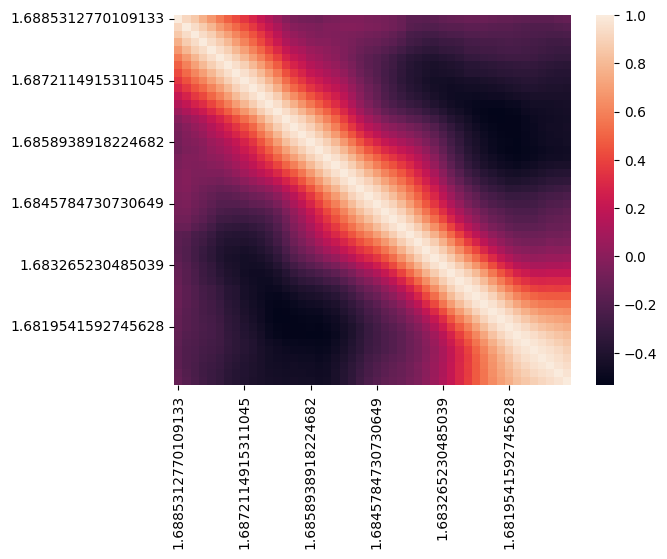

Autocorrelation for 1.6845784730730649 for 30 lags


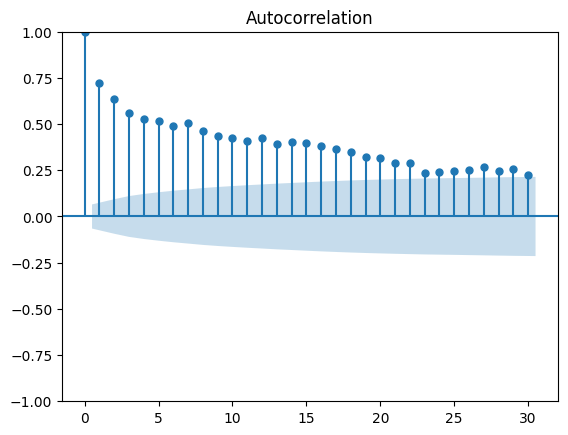

In [48]:
# plot correlation matrix as well as the autocorrelation for the middle wavelegths for band2
corr_auto(df, ss_band2, ee_band2, lags=30, fig_name='band2', ticks=8)

In [49]:
X_train_band2_norm , Y_train_band2_norm , X_val_band2_norm , Y_val_band2_norm , X_test_band2_norm , Y_test_band2_norm, Y_test_band2, X_train_band2, Y_train_band2=df_to_X_Y_band(df, window_size, ss=ss_band2, ee=ee_band2)
X_train_band2_norm.shape , Y_train_band2_norm.shape , X_val_band2_norm.shape , Y_val_band2_norm.shape , X_test_band2_norm.shape , Y_test_band2_norm.shape

((715, 5, 48), (715, 48), (91, 5, 48), (91, 48), (90, 5, 48), (90, 48))

In [54]:
cp_band2=ModelCheckpoint('/model/multivariate/time_series_11/band/band2/' , save_best_only=True) # it saves the best model based on val error
model_band2=pred_model(X_train_band2_norm, Y_train_band2_norm,learning_rate=0.01, batch_size=1)
model_band2.fit(X_train_band2_norm, Y_train_band2_norm, validation_data=(X_val_band2_norm, Y_val_band2_norm), batch_size=1, epochs=60, callbacks=[cp_band2])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (1, 128)                  90624     
                                                                 
 dense_8 (Dense)             (1, 20)                   2580      
                                                                 
 dense_9 (Dense)             (1, 48)                   1008      
                                                                 
Total params: 94,212
Trainable params: 94,212
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
711/715 [============================>.] - ETA: 0s - loss: 0.7720 - root_mean_squared_error: 0.8786

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band2\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band2\assets


715/715 [==============================] - 16s 20ms/step - loss: 0.7718 - root_mean_squared_error: 0.8785 - val_loss: 0.7233 - val_root_mean_squared_error: 0.8505
Epoch 2/60
710/715 [============================>.] - ETA: 0s - loss: 0.4362 - root_mean_squared_error: 0.6605

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band2\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band2\assets


715/715 [==============================] - 11s 16ms/step - loss: 0.4350 - root_mean_squared_error: 0.6596 - val_loss: 0.6243 - val_root_mean_squared_error: 0.7901
Epoch 3/60
707/715 [============================>.] - ETA: 0s - loss: 0.3610 - root_mean_squared_error: 0.6009

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band2\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band2\assets


715/715 [==============================] - 12s 17ms/step - loss: 0.3604 - root_mean_squared_error: 0.6003 - val_loss: 0.5756 - val_root_mean_squared_error: 0.7587
Epoch 4/60
712/715 [============================>.] - ETA: 0s - loss: 0.3322 - root_mean_squared_error: 0.5764

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band2\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band2\assets


715/715 [==============================] - 12s 16ms/step - loss: 0.3326 - root_mean_squared_error: 0.5767 - val_loss: 0.5543 - val_root_mean_squared_error: 0.7445
Epoch 5/60
711/715 [============================>.] - ETA: 0s - loss: 0.3158 - root_mean_squared_error: 0.5620

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band2\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band2\assets


715/715 [==============================] - 13s 18ms/step - loss: 0.3154 - root_mean_squared_error: 0.5616 - val_loss: 0.5378 - val_root_mean_squared_error: 0.7333
Epoch 6/60
714/715 [============================>.] - ETA: 0s - loss: 0.3033 - root_mean_squared_error: 0.5507

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band2\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band2\assets


715/715 [==============================] - 12s 16ms/step - loss: 0.3031 - root_mean_squared_error: 0.5505 - val_loss: 0.5154 - val_root_mean_squared_error: 0.7179
Epoch 7/60
715/715 [==============================] - 3s 5ms/step - loss: 0.2952 - root_mean_squared_error: 0.5433 - val_loss: 0.5162 - val_root_mean_squared_error: 0.7185
Epoch 8/60
711/715 [============================>.] - ETA: 0s - loss: 0.2867 - root_mean_squared_error: 0.5354

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band2\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band2\assets


715/715 [==============================] - 11s 16ms/step - loss: 0.2861 - root_mean_squared_error: 0.5349 - val_loss: 0.5151 - val_root_mean_squared_error: 0.7177
Epoch 9/60
711/715 [============================>.] - ETA: 0s - loss: 0.2811 - root_mean_squared_error: 0.5302

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band2\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band2\assets


715/715 [==============================] - 14s 19ms/step - loss: 0.2805 - root_mean_squared_error: 0.5296 - val_loss: 0.5102 - val_root_mean_squared_error: 0.7143
Epoch 10/60
706/715 [============================>.] - ETA: 0s - loss: 0.2730 - root_mean_squared_error: 0.5225

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band2\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band2\assets


715/715 [==============================] - 14s 20ms/step - loss: 0.2738 - root_mean_squared_error: 0.5232 - val_loss: 0.5081 - val_root_mean_squared_error: 0.7128
Epoch 11/60
711/715 [============================>.] - ETA: 0s - loss: 0.2685 - root_mean_squared_error: 0.5182

INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band2\assets


INFO:tensorflow:Assets written to: /model/multivariate/time_series_11/band/band2\assets


715/715 [==============================] - 15s 20ms/step - loss: 0.2678 - root_mean_squared_error: 0.5175 - val_loss: 0.4894 - val_root_mean_squared_error: 0.6996
Epoch 12/60
715/715 [==============================] - 3s 5ms/step - loss: 0.2620 - root_mean_squared_error: 0.5118 - val_loss: 0.4949 - val_root_mean_squared_error: 0.7035
Epoch 13/60
715/715 [==============================] - 4s 6ms/step - loss: 0.2592 - root_mean_squared_error: 0.5091 - val_loss: 0.5039 - val_root_mean_squared_error: 0.7099
Epoch 14/60
715/715 [==============================] - 4s 5ms/step - loss: 0.2548 - root_mean_squared_error: 0.5048 - val_loss: 0.4908 - val_root_mean_squared_error: 0.7005
Epoch 15/60
715/715 [==============================] - 4s 6ms/step - loss: 0.2521 - root_mean_squared_error: 0.5021 - val_loss: 0.4941 - val_root_mean_squared_error: 0.7030
Epoch 16/60
715/715 [==============================] - 6s 9ms/step - loss: 0.2481 - root_mean_squared_error: 0.4981 - val_loss: 0.5202 - val_root

KeyboardInterrupt: 

90/90 [==============================] - 1s 2ms/step
Total rmse over test set using prediction model is :53.50190759366089


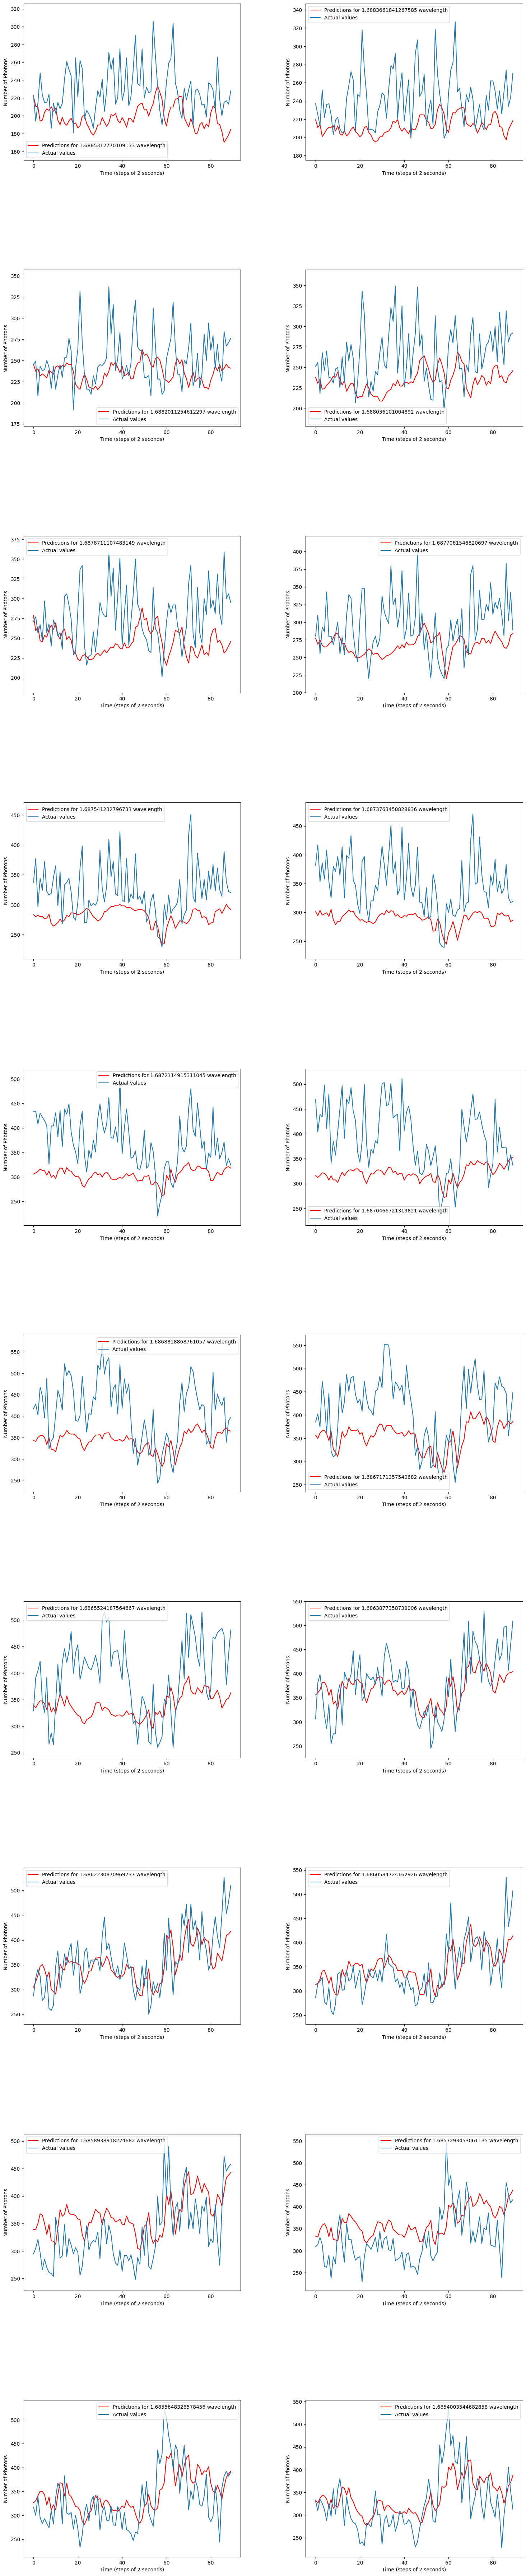

In [55]:
# Plot function and calculate rmse

# load the trained model
model_band2=tf.keras.models.load_model('/model/multivariate/time_series_11/band/band2/')
plot_predictions_band(model_band=model_band2, X_test_band_norm=X_test_band2_norm, X_train_band=X_train_band2, Y_test_band=Y_test_band2, start=0, end=20 ,ss=ss_band2, ee=ee_band2, wave_to_save=19)

90/90 [==============================] - 0s 2ms/step
Total rmse over test set using prediction model is :53.51071249721635
Total rmse over test set using shifted model is :46.173604869058416


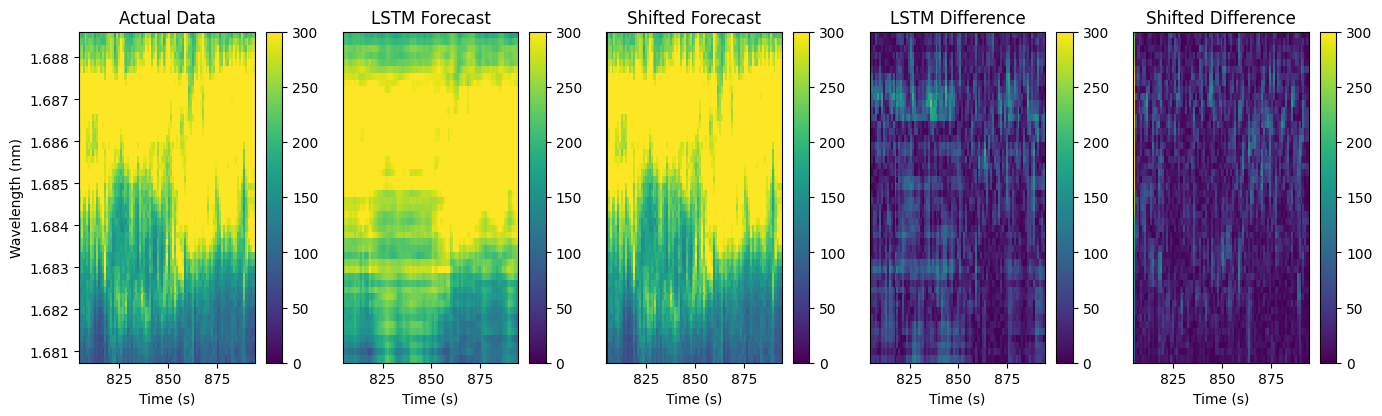

In [60]:
### plot the predictions and actual values as images 

band_image(model_band2, X_test_band2_norm, Y_test_band2, X_train_band2, df_as_np, window_size, ss=ss_band2, ee=ee_band2, thresh1=300, thresh2=300)
# save the images
# plt.savefig(path + 'band2_images.png',dpi=300, bbox_inches='tight', facecolor=(1, 1, 1))

#### Band 3

In [ ]:
### Pick the third band and apply muti variate to them
# plot the data as an image for a range of wave
df_as_np=df.to_numpy(dtype=np.single)

wave=np.array(df.columns)
phot=df_as_np
time=np.array(df.index, dtype=int)

ss_band3=195 #these are for the third band
ee_band3=240

plt.pcolor(time, wave[ss_band3:ee_band3], phot.T[ss_band3:ee_band3])
plt.clim(0, np.amax(phot)) # plot the color bar only up to values of 3000 (max value is max(phot))
plt.colorbar()
plt.xlabel("Time (s)")
plt.ylabel("Wavelength (nm)")
# plt.ylim(ymax = 630, ymin = 618)
plt.show()

In [ ]:
# plot correlation matrix as well as the autocorrelation for the middle wavelegths for band3
corr_auto(df, ss_band3, ee_band3, lags=30, fig_name='band3', ticks=9)

In [ ]:
X_train_band3_norm , Y_train_band3_norm , X_val_band3_norm , Y_val_band3_norm , X_test_band3_norm , Y_test_band3_norm, Y_test_band3, X_train_band3=df_to_X_Y_band(df, window_size, ss=ss_band3, ee=ee_band3)
X_train_band3_norm.shape , Y_train_band3_norm.shape , X_val_band3_norm.shape , Y_val_band3_norm.shape , X_test_band3_norm.shape , Y_test_band3_norm.shape

In [ ]:
cp_band3=ModelCheckpoint('model/publish2/band/band3/' , save_best_only=True) # it saves the best model based on val error
model_band3=pred_model(X_train_band3_norm, Y_train_band3_norm, learning_rate=0.00001, batch_size=1)
model_band3.fit(X_train_band3_norm, Y_train_band3_norm, validation_data=(X_val_band3_norm, Y_val_band3_norm), batch_size=1, epochs=1000, callbacks=[cp_band3])

In [ ]:
# Plot function and calculate rmse
# load the trained model
# model_band3=tf.keras.models.load_model('model/publish2/band/band3/')
plot_predictions_band(model_band3, X_test_band3_norm, X_train_band=X_train_band3, Y_test_band=Y_test_band3, start=0, end=20 ,ss=ss_band3, ee=ee_band3, wave_to_save=13)

In [ ]:
### plot the predictions and actual values as images 

band_image(model_band3, X_test_band3_norm, Y_test_band3, X_train_band3, df_as_np, window_size, ss=ss_band3, ee=ee_band3, thresh1=3000, thresh2=500)
# save the images
path='./Figs/'
plt.savefig(path + 'band3_images.png',dpi=300, bbox_inches='tight', facecolor=(1, 1, 1))

#### Band 4

In [ ]:
### Pick the fourth band and apply muti variate to them
# plot the data as an image for a range of wave
df_as_np=df.to_numpy(dtype=np.single)

wave=np.array(df.columns)
phot=df_as_np
time=np.array(df.index, dtype=int)

ss_band4=245
ee_band4=338

plt.pcolor(time, wave[ss_band4:ee_band4], phot.T[ss_band4:ee_band4])
plt.clim(0, np.amax(phot)) # plot the color bar only up to values of 3000 (max value is max(phot))
plt.colorbar()
plt.xlabel("Time (s)")
plt.ylabel("Wavelength (nm)")
# plt.ylim(ymax = 630, ymin = 618)
plt.show()

In [ ]:
# plot correlation matrix as well as the autocorrelation for the middle wavelegths for band4
corr_auto(df, ss_band4, ee_band4, lags=30, fig_name='band4', ticks=19)

In [ ]:
X_train_band4_norm , Y_train_band4_norm , X_val_band4_norm , Y_val_band4_norm , X_test_band4_norm , Y_test_band4_norm, Y_test_band4, X_train_band4=df_to_X_Y_band(df, window_size, ss=245, ee=338)
X_train_band4_norm.shape , Y_train_band4_norm.shape , X_val_band4_norm.shape , Y_val_band4_norm.shape , X_test_band4_norm.shape , Y_test_band4_norm.shape

In [ ]:
cp_band4=ModelCheckpoint('model/publish2/band/band4/' , save_best_only=True) # it saves the best model based on val error
model_band4=pred_model(X_train_band4_norm, Y_train_band4_norm, batch_size=1)
model_band4.fit(X_train_band4_norm, Y_train_band4_norm, validation_data=(X_val_band4_norm, Y_val_band4_norm), batch_size=1, epochs=1300, callbacks=[cp_band4])

In [ ]:
# Plot function and calculate rmse
# load the trained model
model_band4=tf.keras.models.load_model('model/publish2/band/band4/')
plot_predictions_band(model_band4, X_test_band4_norm, X_train_band=X_train_band4, Y_test_band=Y_test_band4, start=0, end=20 ,ss=ss_band4, ee=ee_band4, wave_to_save=13)

In [ ]:
### plot the predictions and actual values as images 

band_image(model_band4, X_test_band4_norm, Y_test_band4, X_train_band4, df_as_np, window_size, ss=ss_band4, ee=ee_band4, thresh1=3000, thresh2=500)
# save the images
path='./Figs/'
plt.savefig(path + 'band4_images.png',dpi=300, bbox_inches='tight', facecolor=(1, 1, 1))